In [21]:
# Use seaborn for pairplot
!pip install -q seaborn

# Use some functions from tensorflow_docs
!pip install -q git+https://github.com/tensorflow/docs

In [22]:
import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

2.2.0


In [29]:
dataset_path='/content/drive/My Drive/FYP/fnlworto.csv'
column_names = ['Length','Cws','Bif','iRTT','RTO']

raw_dataset = pd.read_csv(dataset_path)
#dataset = dataset.dropna()
dataset = raw_dataset.copy()
dataset = dataset.replace(np.nan, 0)
dataset = dataset.fillna(0)
dataset.head()

,Length,Cws,Bif,iRTT
0,162,4096,96.0,0.000000
1,129,131072,63.0,0.094459
2,150,65792,84.0,0.096282
3,100,39680,46.0,0.093189
4,145,262400,91.0,0.077056


In [30]:
dataset.shape[0]

255513

In [31]:
dataset.dtypes

Length      int64
Cws         int64
Bif       float64
iRTT      float64
dtype: object

In [0]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

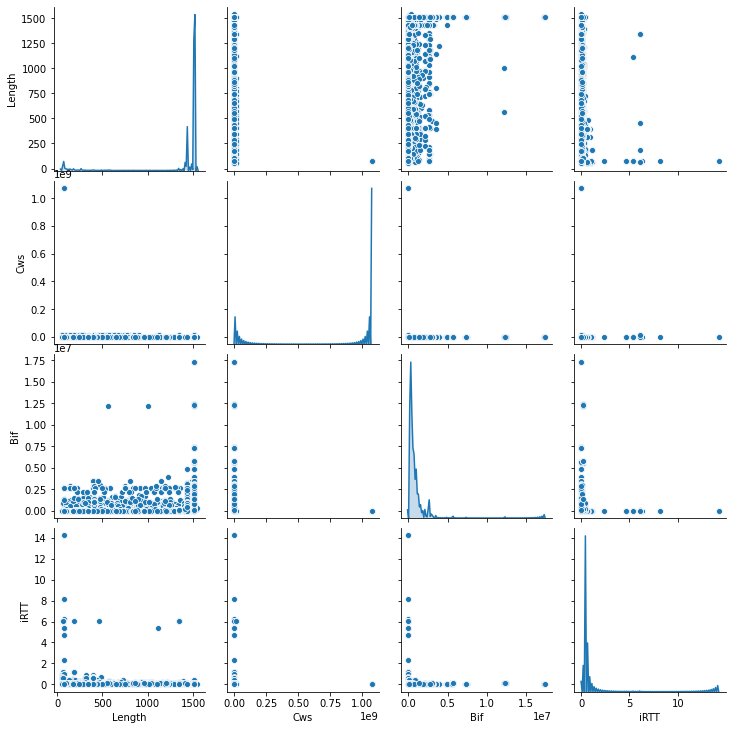

In [0]:
sns.pairplot(train_dataset[["Length", "Cws", "Bif", "iRTT"]], diag_kind="kde")

In [0]:
train_stats = train_dataset.describe()
train_stats.pop("iRTT")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Length,204410.0,1347.465667,4.217618e+02,54.0,1434.0,1514.0,1514.0,1.539000e+03
Cws,204410.0,169066.628932,1.064291e+07,1.0,249.0,27008.0,31744.0,1.073725e+09
Bif,204410.0,372509.354821,7.185847e+05,0.0,10220.0,132860.0,449734.0,1.733935e+07


In [0]:
train_labels = train_dataset.pop('iRTT')
test_labels = test_dataset.pop('iRTT')

In [0]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [0]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [0]:
model = build_model()

In [0]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

array([[-0.04118488],
       [ 0.00495283],
       [ 0.06861888],
       [ 0.0708357 ],
       [ 0.07199419],
       [-0.03810812],
       [ 0.04426418],
       [ 0.07050812],
       [-0.02758497],
       [-0.04352941]], dtype=float32)

In [0]:
EPOCHS = 1000

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2, verbose=0,
  callbacks=[tfdocs.modeling.EpochDots()])


Epoch: 0, loss:0.0127,  mae:0.0433,  mse:0.0127,  val_loss:0.0123,  val_mae:0.0452,  val_mse:0.0123,  
....................................................................................................
Epoch: 100, loss:0.0479,  mae:0.0350,  mse:0.0479,  val_loss:0.0280,  val_mae:0.0324,  val_mse:0.0280,  
....................................................................................................
Epoch: 200, loss:0.0365,  mae:0.0342,  mse:0.0365,  val_loss:0.0103,  val_mae:0.0333,  val_mse:0.0103,  
....................................................................................................
Epoch: 300, loss:0.0851,  mae:0.0346,  mse:0.0851,  val_loss:0.1997,  val_mae:0.0371,  val_mse:0.1997,  
....................................................................................................
Epoch: 400, loss:0.3538,  mae:0.0350,  mse:0.3538,  val_loss:0.4019,  val_mae:0.0415,  val_mse:0.4019,  
........................................................................

In [0]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
995,0.439166,0.035822,0.439166,0.320237,0.037333,0.320237,995
996,0.490280,0.036955,0.490280,1.839188,0.052859,1.839188,996
997,0.485279,0.036141,0.485279,0.036443,0.032147,0.036443,997
998,0.400296,0.035868,0.400296,0.034099,0.033245,0.034099,998
999,0.440123,0.035703,0.440123,0.036534,0.034695,0.036534,999


In [0]:
plotter = tfdocs.plots.HistoryPlotter(smoothing_std=2)

Text(0, 0.5, 'MAE [RTT]')

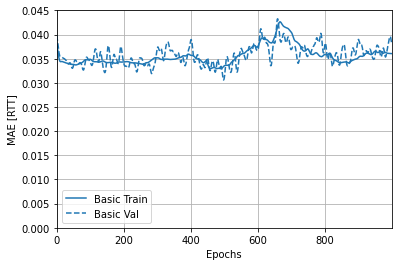

In [0]:
plotter.plot({'Basic': history}, metric = "mae")
plt.ylim([0, 0.045])
plt.ylabel('MAE [RTT]')

Text(0, 0.5, 'MSE [RTT^2]')

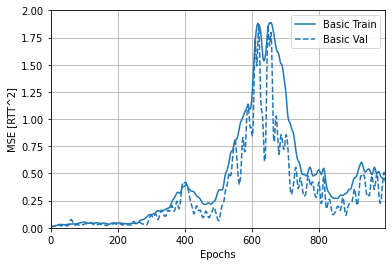

In [0]:
plotter.plot({'Basic': history}, metric = "mse")
plt.ylim([0, 2])
plt.ylabel('MSE [RTT^2]')

In [0]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

early_history = model.fit(normed_train_data, train_labels, 
                    epochs=EPOCHS, validation_split = 0.2, verbose=0, 
                    callbacks=[early_stop, tfdocs.modeling.EpochDots()])

In [0]:
loss, mae, mse = model.evaluate(normed_test_data, test_labels, verbose=2)

print("Testing set Mean Abs Error: {:5.2f} RTT".format(mae))

1597/1597 - 2s - loss: 0.0766 - mae: 0.0373 - mse: 0.0766
Testing set Mean Abs Error:  0.04 RTT


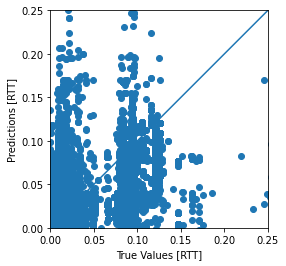

In [0]:
test_predictions = model.predict(normed_test_data).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [RTT]')
plt.ylabel('Predictions [RTT]')
lims = [0, 0.25]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


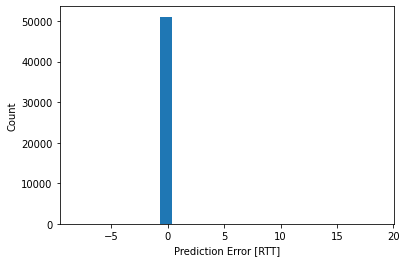

In [0]:
error = test_predictions - test_labels
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [RTT]")
_ = plt.ylabel("Count")

In [0]:
#model.save('/content/drive/My Drive/FYP/my_modelnew1.h5')